In [1]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from keras.applications.vgg16 import (
    VGG16, 
    preprocess_input, 
    decode_predictions)



Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12831117900602994261
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6707519816
locality {
  bus_id: 1
}
incarnation: 16565509246289722329
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
#assigns GPU to backend (dont use this code if running off CPU)
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
#Confusion Matrix plot from scikitlearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
#split animals folder into training, validation, and testing sets

import split_folders
split_folders.ratio('./animals', output="split_images", seed=1337, ratio=(.8, .1, .1))

In [6]:
#Assign Folder Paths
train_path = './split_images/train'
valid_path = './split_images/val'
test_path = './split_images/test'

In [49]:
# assign batches for training and testing

train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=391)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=47)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['coyote','grey fox','kit fox','tortoise'],batch_size=53)

Found 391 images belonging to 4 classes.
Found 47 images belonging to 4 classes.
Found 53 images belonging to 4 classes.


In [29]:
test_batches.class_indices

{'coyote': 0, 'grey fox': 1, 'kit fox': 2, 'tortoise': 3}

In [11]:
#function to plot images

def plots(ims, figsize=(12,6),rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        

c:\users\tpython\anaconda3\envs\tfgpu15\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


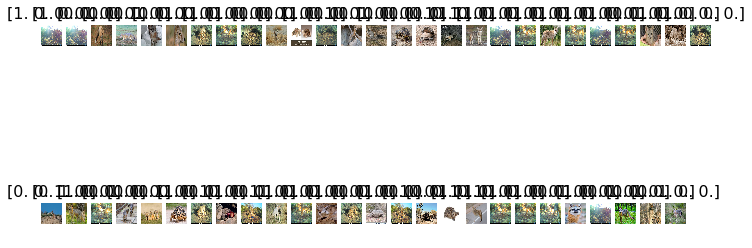

In [12]:
#Check out images
ims, labels = next(test_batches)
plots(ims, titles=labels)

In [13]:
#load VGG16 to train
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
#copy VGG16 all layer except last output layer to new sequential model
model2 = Sequential()
for layer in vgg16_model.layers[:-1]:
    model2.add(layer)
    
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [15]:
#freeze all layers but the last output layer
for layer in model2.layers:
    layer.trainable = False

In [16]:
#add  dense 4 category output layer to model for retraining
model2.add(Dense(4, activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [17]:
# compile with adam optimizer 
model2.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
# create datagens to flow data into fit generator/model trainer

batch_size = 32

train_datagen = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        channel_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        )

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        './split_images/val',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')


train_generator = train_datagen.flow_from_directory(
        './split_images/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 299x299
        batch_size=batch_size,
        class_mode='categorical')

steps_per_epoch = train_generator.n//train_generator.batch_size

Found 47 images belonging to 4 classes.
Found 391 images belonging to 4 classes.


In [24]:
#fit the model
model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, epochs=20, verbose=2 )

Epoch 1/20
 - 4s - loss: 0.2909 - acc: 0.8893 - val_loss: 1.1307 - val_acc: 0.6170
Epoch 2/20
 - 4s - loss: 0.2261 - acc: 0.9076 - val_loss: 1.1173 - val_acc: 0.5957
Epoch 3/20
 - 4s - loss: 0.2923 - acc: 0.8919 - val_loss: 1.1376 - val_acc: 0.6170
Epoch 4/20
 - 4s - loss: 0.2725 - acc: 0.8886 - val_loss: 1.1353 - val_acc: 0.6170
Epoch 5/20
 - 4s - loss: 0.2613 - acc: 0.8964 - val_loss: 1.1788 - val_acc: 0.6383
Epoch 6/20
 - 4s - loss: 0.2460 - acc: 0.9129 - val_loss: 1.2056 - val_acc: 0.6383
Epoch 7/20
 - 4s - loss: 0.2633 - acc: 0.9076 - val_loss: 1.1846 - val_acc: 0.6383
Epoch 8/20
 - 4s - loss: 0.2184 - acc: 0.9167 - val_loss: 1.1677 - val_acc: 0.6383
Epoch 9/20
 - 4s - loss: 0.1989 - acc: 0.9293 - val_loss: 1.1414 - val_acc: 0.6383
Epoch 10/20
 - 4s - loss: 0.2415 - acc: 0.8972 - val_loss: 1.1377 - val_acc: 0.6170
Epoch 11/20
 - 4s - loss: 0.2229 - acc: 0.9057 - val_loss: 1.1302 - val_acc: 0.6170
Epoch 12/20
 - 4s - loss: 0.2057 - acc: 0.9181 - val_loss: 1.1290 - val_acc: 0.5745
E

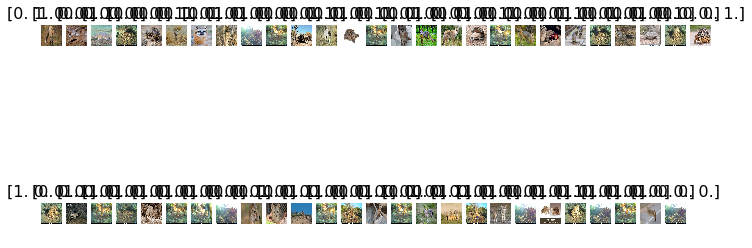

In [25]:
#assign test images to test batch and display
test_ims, test_labels = next(test_batches)
plots(test_ims, titles=test_labels)

1/1 [==============================] - 0s 455ms/step
Confusion matrix, without normalization
[[25  2  0  0]
 [ 4  6  1  0]
 [ 2  3  2  0]
 [ 0  0  0  8]]


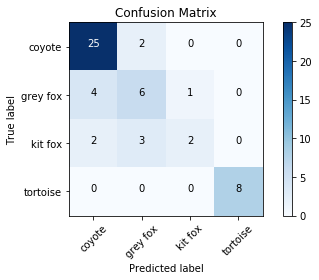

In [26]:
#create confusion matrix to display results
predictions = model2.predict_generator(test_batches, steps=1, verbose=1)
cm = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))
cm_plot_labels = ['coyote', 'grey fox','kit fox', 'tortoise']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [27]:
#crteate classification report to display results on test batch predictions
from sklearn.metrics import classification_report
y_true = test_labels.argmax(axis=1)
y_pred = predictions.argmax(axis=1)
target_names = ['coyote', 'grey fox','kit fox', 'tortoise']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      coyote       0.81      0.93      0.86        27
    grey fox       0.55      0.55      0.55        11
     kit fox       0.67      0.29      0.40         7
    tortoise       1.00      1.00      1.00         8

   micro avg       0.77      0.77      0.77        53
   macro avg       0.75      0.69      0.70        53
weighted avg       0.76      0.77      0.76        53



In [283]:
model.save_weights('Re-trained2.h5')

In [50]:
#now try to retrain inceptionV3 model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 4 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model1 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
batch_size = 16

#assign training,testing, and validation generators
train_datagen1 = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        channel_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        )

test_datagen1 = ImageDataGenerator(rescale=1./255)

validation_generator1 = test_datagen1.flow_from_directory(
        valid_path,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical')



train_generator1 = train_datagen1.flow_from_directory(
        './split_images/train',  # this is the target directory
        target_size=(299, 299),  # all images will be resized to 299x299
        batch_size=batch_size,
        class_mode='categorical')
    

steps_per_epoch = train_generator1.n//train_generator1.batch_size

Found 47 images belonging to 4 classes.
Found 391 images belonging to 4 classes.


In [51]:

# compile the model (should be done *after* setting layers to non-trainable)
model1.compile(optimizer='Adam', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model1.fit_generator(train_generator1, steps_per_epoch=steps_per_epoch, validation_data=validation_generator1, epochs=5, verbose=2 )


# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

Epoch 1/5
 - 8s - loss: 1.1353 - val_loss: 0.3747
Epoch 2/5
 - 7s - loss: 0.5220 - val_loss: 0.1619
Epoch 3/5
 - 7s - loss: 0.2734 - val_loss: 0.3731
Epoch 4/5
 - 7s - loss: 0.3833 - val_loss: 0.2011
Epoch 5/5
 - 7s - loss: 0.3126 - val_loss: 0.2258


In [46]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model1.layers[:249]:
   layer.trainable = False
for layer in model1.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use adam with a low learning rate

model1.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model1.fit_generator(train_generator1, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, epochs=20, verbose=2 )


0 input_4
1 conv2d_189
2 batch_normalization_189
3 activation_189
4 conv2d_190
5 batch_normalization_190
6 activation_190
7 conv2d_191
8 batch_normalization_191
9 activation_191
10 max_pooling2d_9
11 conv2d_192
12 batch_normalization_192
13 activation_192
14 conv2d_193
15 batch_normalization_193
16 activation_193
17 max_pooling2d_10
18 conv2d_197
19 batch_normalization_197
20 activation_197
21 conv2d_195
22 conv2d_198
23 batch_normalization_195
24 batch_normalization_198
25 activation_195
26 activation_198
27 average_pooling2d_19
28 conv2d_194
29 conv2d_196
30 conv2d_199
31 conv2d_200
32 batch_normalization_194
33 batch_normalization_196
34 batch_normalization_199
35 batch_normalization_200
36 activation_194
37 activation_196
38 activation_199
39 activation_200
40 mixed0
41 conv2d_204
42 batch_normalization_204
43 activation_204
44 conv2d_202
45 conv2d_205
46 batch_normalization_202
47 batch_normalization_205
48 activation_202
49 activation_205
50 average_pooling2d_20
51 conv2d_201
52 

1/1 [==============================] - 2s 2s/step
Confusion matrix, without normalization
[[27  0  0  0]
 [11  0  0  0]
 [ 7  0  0  0]
 [ 8  0  0  0]]


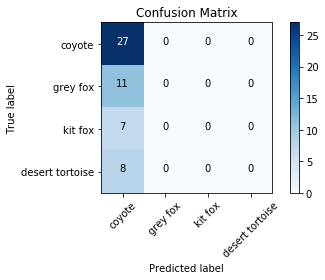

In [52]:
predictions2 = model1.predict_generator(test_batches, steps=1, verbose=1)
cm = confusion_matrix(test_labels.argmax(axis=1), predictions2.argmax(axis=1))
cm_plot_labels = ['coyote','grey fox','kit fox','desert tortoise']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


In [53]:
v3y_true = test_labels.argmax(axis=1)
v3y_pred = predictions2.argmax(axis=1)
target_names = ['coyote', 'grey fox','kit fox', 'tortoise']
print(classification_report(v3y_true, v3y_pred, target_names=target_names))

              precision    recall  f1-score   support

      coyote       0.51      1.00      0.67        27
    grey fox       0.00      0.00      0.00        11
     kit fox       0.00      0.00      0.00         7
    tortoise       0.00      0.00      0.00         8

   micro avg       0.51      0.51      0.51        53
   macro avg       0.13      0.25      0.17        53
weighted avg       0.26      0.51      0.34        53



In [ ]:
model1.save_weights('terrible_model.h5')